## Install required libraries

In [1]:
%pip install transformers
%pip install rwkv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [2]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.utils.checkpoint
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from typing import List, Optional, Tuple, Union

from math import floor

from transformers.models.rwkv.configuration_rwkv import RwkvConfig
from transformers.models.rwkv.modeling_rwkv import RwkvBlock, RwkvPreTrainedModel, RwkvOutput

In [3]:
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

## Custom model - RWKV
Based on HuggingFace RWKV model

In [4]:
# coding=utf-8
# Copyright 2023 Bo Peng and HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch RWKV model."""

rwkv_cuda_kernel = None

class EarthquakePredictorRWKV(RwkvPreTrainedModel):
    def __init__(self, config, input_size=1, output_size=1):
        super().__init__(config)
        
        self.embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        
        # fc1
        self.input_linear = nn.Linear(input_size, config.hidden_size)
        
        # ReLU and Dropout layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
        self.blocks = nn.ModuleList([RwkvBlock(config, layer_id=idx) for idx in range(config.num_hidden_layers)])
        self.ln_out = nn.LayerNorm(config.hidden_size)
        
        # Output linear layer
        self.output_linear = nn.Linear(config.hidden_size, output_size)
        
        self.layers_are_rescaled = False

        self.gradient_checkpointing = False

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings

    def set_input_embeddings(self, new_embeddings):
        self.embeddings = new_embeddings

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,  # noqa
        inputs_embeds: Optional[torch.FloatTensor] = None,
        state: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, RwkvOutput]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else (self.config.use_cache if not self.training else False)
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.training == self.layers_are_rescaled:
            self._rescale_layers()

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is None and inputs_embeds is None:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if use_cache and state is None:
            shape = (inputs_embeds.size(0), self.config.hidden_size, self.config.num_hidden_layers)
            state = [
                torch.zeros(
                    *shape, dtype=inputs_embeds.dtype if i <= 1 else torch.float32, device=inputs_embeds.device
                )
                for i in range(5)
            ]
            state[4] -= 1e30

        if self.gradient_checkpointing and self.training:
            if use_cache:
                print("`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...")
                use_cache = False

        hidden_states = self.relu(self.input_linear(input_ids))

        all_self_attentions = () if output_attentions else None
        all_hidden_states = () if output_hidden_states else None
        for idx, block in enumerate(self.blocks):
            if self.gradient_checkpointing and self.training:
                hidden_states, state, attentions = self._gradient_checkpointing_func(
                    block.__call__, hidden_states, state, use_cache, output_attentions
                )
            else:
                hidden_states, state, attentions = block(
                    hidden_states, state=state, use_cache=use_cache, output_attentions=output_attentions
                )

            if (
                self.layers_are_rescaled
                and self.config.rescale_every > 0
                and (idx + 1) % self.config.rescale_every == 0
            ):
                hidden_states = hidden_states / 2

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if output_attentions:
                all_self_attentions = all_self_attentions + (attentions,)

        hidden_states = self.output_linear(self.ln_out(hidden_states))

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(x for x in [hidden_states, state, all_hidden_states, all_self_attentions] if x is not None)

        return RwkvOutput(
            last_hidden_state=hidden_states,
            state=state,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
        )

    def _rescale_layers(self):
        # Layers should be rescaled for inference only.
        if self.layers_are_rescaled == (not self.training):
            return
        if self.config.rescale_every > 0:
            with torch.no_grad():
                for block_id, block in enumerate(self.blocks):
                    if self.training:
                        block.attention.output.weight.mul_(2 ** int(block_id // self.config.rescale_every))
                        block.feed_forward.value.weight.mul_(2 ** int(block_id // self.config.rescale_every))
                    else:
                        # Deal with quantization statistics
                        if hasattr(block.attention.output.weight, "SCB"):
                            block.attention.output.weight.SCB.div_(2 ** int(block_id // self.config.rescale_every))
                            block.feed_forward.value.weight.SCB.div_(2 ** int(block_id // self.config.rescale_every))
                        elif hasattr(block.attention.output.weight, "quant_state"):
                            self._bnb_4bit_dequantize_and_rescale(block.attention.output, block_id)
                            self._bnb_4bit_dequantize_and_rescale(block.feed_forward.value, block_id)
                        else:
                            block.attention.output.weight.div_(2 ** int(block_id // self.config.rescale_every))
                            block.feed_forward.value.weight.div_(2 ** int(block_id // self.config.rescale_every))

        self.layers_are_rescaled = not self.training


## Model configuration

In [5]:
window_size = 50
num_rwkv_layers = 24
hidden_size = 32
context = 50
batch_size = 25

## Data loading

      Olus tarihi  count
49999  1994.09.11      1
49997  1994.09.13      2
49996  1994.09.15      1
49995  1994.09.16      1
49992  1994.09.17      3
...           ...    ...
17     2023.07.27      3
15     2023.07.28      2
7      2023.07.29      8
3      2023.07.30      4
0      2023.07.31      3

[9639 rows x 2 columns]


Text(0.5, 1.0, 'Number of earthquakes in Turkey vs. Date')

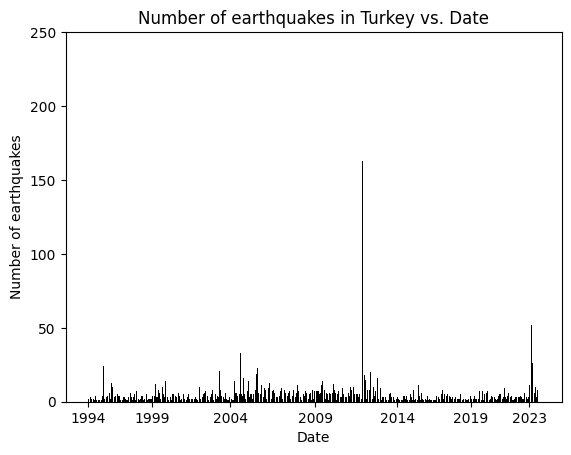

In [6]:
dataset = pd.read_csv('C:/Technion/Git/046211-Deep-Learning/Data/veriler.csv')

dataset['count'] = dataset.groupby('Olus tarihi')['Olus tarihi'].transform('count')
dataset = dataset[["Olus tarihi", "count"]]
dataset = dataset.drop_duplicates()
dataset = dataset.iloc[::-1]
print(dataset)


plt.bar(dataset["Olus tarihi"], dataset["count"], color="black")
plt.xlabel("Date")
df_fo_graph = [year[:4] for year in dataset["Olus tarihi"]]
xticks = [df_fo_graph.index(str(year)) for year in range(1994, 2023)][0::5]
xticks.append(df_fo_graph.index(str('2023')))
xticks_labels = list(range(1994, 2023))[0::5]
xticks_labels.append('2023')
plt.xticks(ticks=xticks, labels=xticks_labels)
plt.ylim((0, 250))
plt.ylabel("Number of earthquakes")
plt.title("Number of earthquakes in Turkey vs. Date")

## Data pre-processing

In [7]:
def create_x_sample(x: np.ndarray, window_size):
    number_of_rows = x.shape[0] - window_size + 1
    
    if number_of_rows <= 0:
        raise ValueError("Window size is larger than the input array size.")
    
    input_data = np.zeros((number_of_rows, window_size))
    
    for i in range(number_of_rows):
        input_data[i] = x[i:i+window_size]
    
    return input_data

def create_window_samples(data: np.ndarray, window_size):
    num_of_samples = data.shape[1]
    mat_x = []
    for i in range(num_of_samples):
        row = data[:,i].T
        row_x = create_x_sample(row, window_size)
        mat_x.append(row_x)
    return np.array(mat_x)

data_raw = dataset[['count']].to_numpy()
num_data_points = data_raw.shape[0]

x_vector = create_window_samples(data_raw, window_size=window_size)
x_vector = np.moveaxis(x_vector, 0, 2)

y_labels = data_raw[window_size:]

# Split dataset
split_train_val = floor(num_data_points * (60 /100))
split_val_to_test = floor(num_data_points * (80 /100))

x_vector_train = x_vector[:split_train_val]
y_labels_train = y_labels[:split_train_val]

x_vector_val = x_vector[split_train_val:split_val_to_test]
y_labels_val = y_labels[split_train_val:split_val_to_test]

x_vector_test = x_vector[split_val_to_test:]
y_labels_test = y_labels[split_val_to_test:]

## Data visualization

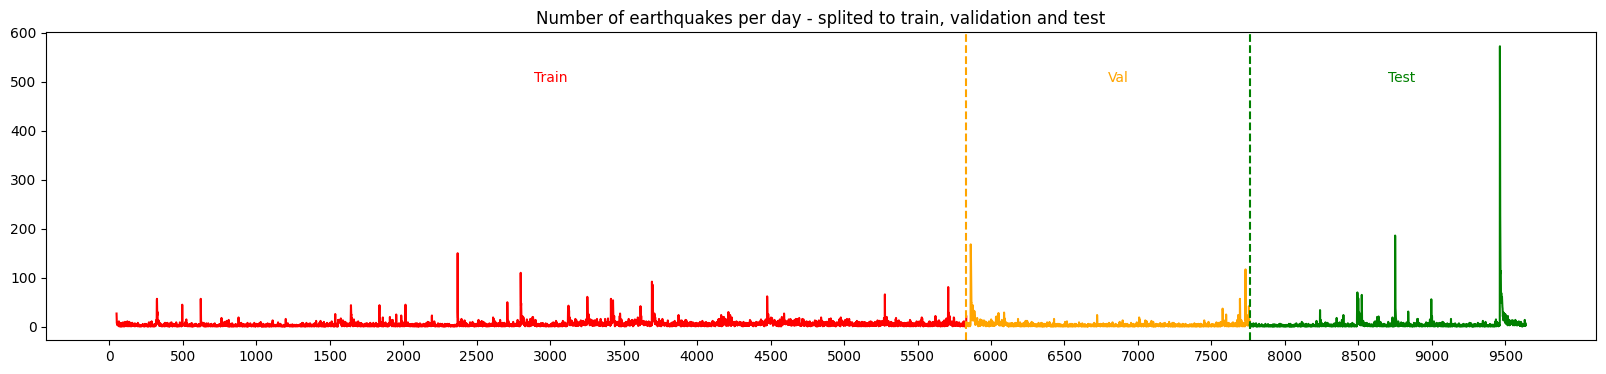

In [8]:
plotting_y_train = np.array([None] * window_size + list(y_labels_train[:, 0]) + [None] * (num_data_points-(split_train_val+window_size)))
plotting_y_val = np.array([None] * (split_train_val+window_size) + list(y_labels_val[:, 0]) + [None] * (num_data_points-(split_val_to_test+window_size)))
plotting_y_test = np.array([None] * (split_val_to_test+window_size) + list(y_labels_test[:, 0]))

## plots
data_date = np.arange(num_data_points)
fig = plt.figure(figsize=(20, 4))
plt.title("Number of earthquakes per day - splited to train, validation and test")

xticks = data_date[0:num_data_points:500]
plt.xticks(xticks, xticks)

plt.plot(data_date, plotting_y_train, label="Number of earthquakes (train)", color='red')
plt.plot(data_date, plotting_y_val, label="Number of earthquakes (validation)", color='orange')
plt.plot(data_date, plotting_y_test, label="Number of earthquakes (test)", color='green')

plt.text(x=(split_train_val) / 2, y=500, s="Train", color="red")
plt.text(x=(split_val_to_test + split_train_val) / 2 +window_size, y=500, s="Val", color='orange')
plt.text(x=(num_data_points + (split_val_to_test+window_size)) / 2, y=500, s="Test", color='green')

plt.axvline(x=split_train_val+window_size, color='orange', linestyle='--')
plt.axvline(x=split_val_to_test+window_size, color='green', linestyle='--')

plt.show()

## Dataloaders

In [9]:
### Need to be changed

# Convert data to float32
x_vector_train = x_vector_train.astype(np.float32)
y_labels_train = y_labels_train.astype(np.float32)
x_vector_val = x_vector_val.astype(np.float32)
y_labels_val = y_labels_val.astype(np.float32)
x_vector_test = x_vector_test.astype(np.float32)
y_labels_test = y_labels_test.astype(np.float32)

# Create lists of tuples for train, validation, and test datasets
dataset_train = [(x, y) for x, y in zip(x_vector_train, y_labels_train)]
dataset_val = [(x, y) for x, y in zip(x_vector_val, y_labels_val)]
dataset_test = [(x, y) for x, y in zip(x_vector_test, y_labels_test)]

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Model creation

In [10]:
rwkv_config = RwkvConfig(vocab_size=0, context_length=context, hidden_size=hidden_size, use_cache=False, num_hidden_layers=num_rwkv_layers)

model = EarthquakePredictorRWKV(rwkv_config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'The device that is being used is: {device}')

print(model)

The device that is being used is: cpu
EarthquakePredictorRWKV(
  (embeddings): Embedding(0, 32)
  (input_linear): Linear(in_features=1, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0): RwkvBlock(
      (pre_ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (attention): RwkvSelfAttention(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=32, out_features=32, bias=False)
        (value): Linear(in_features=32, out_features=32, bias=False)
        (receptance): Linear(in_features=32, out_features=32, bias=False)
        (output): Linear(in_features=32, out_features=32, bias=False)
      )
      (feed_forward): RwkvFeedForward(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=32, out_features=128, bias=False)
    

## Training hyper-parameters

In [11]:
epochs = 25
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.5, verbose=True)

c:\Technion\Git\046211-Deep-Learning\venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training and Evaluation

In [12]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Class to have default values for test results
class TestStepResults:
    def __init__(self):
        self.MIN_MAE = float('inf')
        self.MIN_MAPE = float('inf')
        self.min_pred = []
        self.best_results = []


# Train step function
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):

    # train mode
    model.train()

    # train loss
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):

        # print(f"Batch {batch}, Input Size: {X.size()}, Target Size: {y.size()}")

        # send data to device
        X, y = X.to(device), y.to(device)

        # forward pass
        y_pred = model(X)
        y_pred = y_pred.last_hidden_state[:,-1,0]

        # calculate the loss
        loss = loss_fn(y_pred, y[:, 0].contiguous())
        train_loss += loss

        # optimize the zero grad
        optimizer.zero_grad()

        # loss backwards
        loss.backward()

        # optimizer step
        optimizer.step()

    # Loss and accuracy normalization according to the length of the dataloader
    train_loss /= len(dataloader)

    return train_loss

# Test step function
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              results: TestStepResults = TestStepResults()):
    
    # test_loss
    test_loss = 0
    pred = []
    targ = []

    # eval mode
    model.eval()
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(dataloader):

            # send data to device
            X_test, y_test = X_test.to(device), y_test.to(device)

            # forward pass
            y_test_pred = model(X_test)
            y_test_pred = y_test_pred.last_hidden_state[:,-1,0]

            pred.extend(y_test_pred.tolist())
            targ.extend(y_test.squeeze(dim=1).tolist())

            #calculate the loss
            loss = loss_fn(y_test_pred, y_test[:, 0].contiguous())
            test_loss += loss

        # Loss normalization according to the length of the dataloader
        test_loss /= len(dataloader)

    MAE = mean_absolute_error(pred, targ)
    MAPE = mean_absolute_percentage_error(pred, targ)
    print ('-' * 50)
    print ('-' * 50)
    print('\nTest MAE:{:.8f}\t Test MAPE:{:.8f} %'.format(MAE, MAPE * 100)) ###

    # Find the minimum values of MAE, MAPE and the best predictions and weights
    if MAPE < results.MIN_MAPE:
        results.min_pred = pred # the best prediction for all the test set
        results.best_results = model.state_dict() # updating the best weights
    results.MIN_MAE = min(results.MIN_MAE, MAE)
    results.MIN_MAPE = min(results.MIN_MAPE, MAPE)

    return test_loss, results.MIN_MAE, results.MIN_MAPE * 100, results.min_pred, results.best_results


# Actual training and testing function
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          scheduler: torch.optim.lr_scheduler = None):
    
    # empty results dictionary
    results = {'train_loss': [],
               'test_loss': []}

    for epoch in tqdm(range(epochs)):

        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
                
        test_loss, MIN_MAE, MIN_MAPE, min_pred, best_weights = test_step(model=model,
                                                                               dataloader=test_dataloader,
                                                                               loss_fn=loss_fn)
        
        # Step the scheduler
        scheduler.step()
        
        # printing the progress
        print(f'Epoch: {epoch+1} |\t \
              Train loss: {train_loss:.8f} |\t \
              Test loss: {test_loss:.8f}')
        
        # update results dictionary to a list
        results['train_loss'].append(train_loss.item())
        results['test_loss'].append(test_loss.item())

        # Printing (in the last iteration) the best MAE and MAPE from all the epochs
        if epoch == epochs - 1:
            # Best MAE, MAPE
            print(f'Best MAE is: {MIN_MAE:.8f}')
            print(f'Best MAPE is: {MIN_MAPE:.8f} %')
            # Best loss
            print(f"Best train loss is: {min(results['train_loss']):.8f}")
            print(f"Best test loss is: {min(results['test_loss']):.8f}")

    return results, best_weights



In [13]:

def convert_seconds(seconds):
    '''Calculate hours, minutes, and seconds'''
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    time_dict = {'Hours': int(hours),
                 'Minutes': int(minutes),
                 'Seconds': int(seconds)}
    return time_dict


# set timer to measure how long it takes to train
start_time = timer()

# training
model_results, best_model = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs, scheduler)

# end time
end_time = timer()

# default value for training time (will be changed according to actual time, otherwise indication of a problem)
total_time = 0

# total time
total_time = end_time - start_time

# get the time it took to run in the correct form
time_dict = convert_seconds(total_time)

# print the total training time
print(f"Total training time is: {time_dict['Hours']}:{time_dict['Minutes']}:{time_dict['Seconds']} (h:m:s)")


  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------------------------
--------------------------------------------------

Test MAE:2.53140465	 Test MAPE:57.26167043 %
Epoch: 1 |	               Train loss: 31.76202774 |	               Test loss: 57.20769501
--------------------------------------------------
--------------------------------------------------

Test MAE:2.42486172	 Test MAPE:61.73240470 %
Epoch: 2 |	               Train loss: 27.63673973 |	               Test loss: 52.58233261
--------------------------------------------------
--------------------------------------------------

Test MAE:2.84421841	 Test MAPE:51.93440402 %
Epoch: 3 |	               Train loss: 29.55214691 |	               Test loss: 52.63845825
--------------------------------------------------
--------------------------------------------------

Test MAE:2.56995622	 Test MAPE:56.73502554 %
Epoch: 4 |	               Train loss: 27.99276352 |	               Test loss: 58.17987442
------------------------------------------------

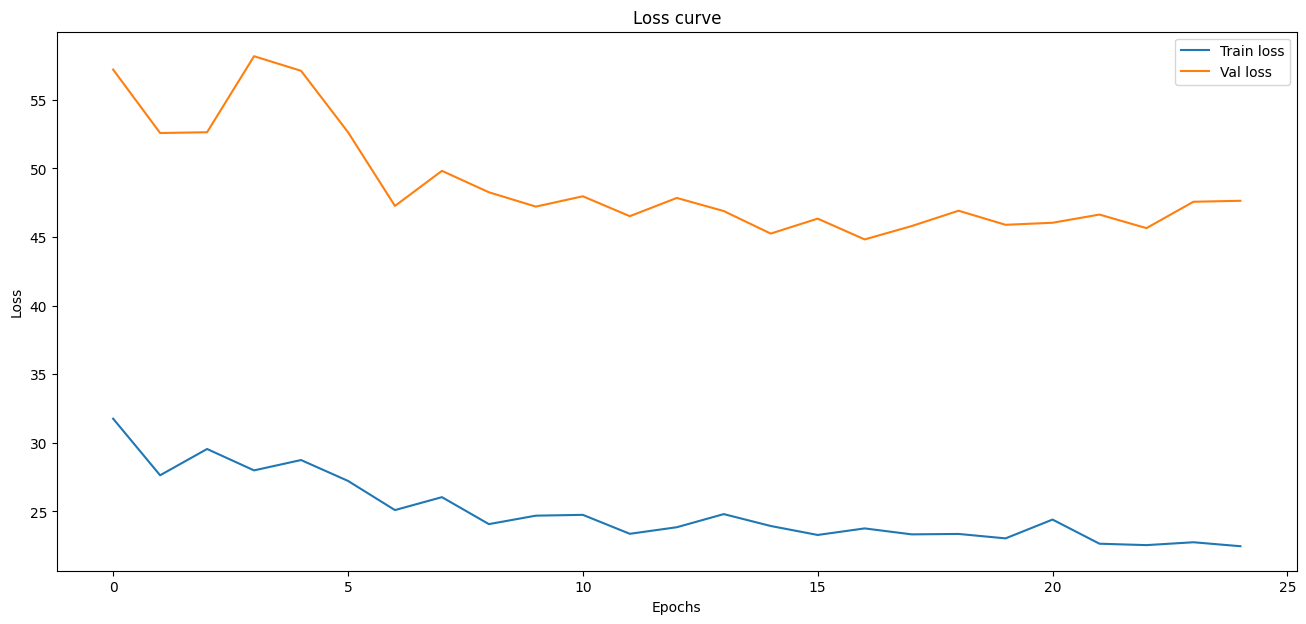

In [14]:
# Loss

# get the num of epochs
epoch_plot = range(len(model_results['train_loss']))

# setup a plot
plt.figure(figsize=(16, 7))

# ploting
plt.plot(epoch_plot, model_results['train_loss'], label='Train loss')
plt.plot(epoch_plot, model_results['test_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

In [15]:

from torch.utils.data import ConcatDataset

# Assuming you have dataloader_1 and dataloader_2 already defined

# Concatenate the datasets
concatenated_dataset = ConcatDataset([dataset_train, dataset_val])

# Create a DataLoader for the concatenated dataset
concatenated_dataloader = DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)


# set timer to measure how long it takes to train
start_time = timer()

# training
model_results, best_model = train(model, concatenated_dataloader, test_dataloader, loss_fn, optimizer, epochs, scheduler)

# end time
end_time = timer()

# default value for training time (will be changed according to actual time, otherwise indication of a problem)
total_time = 0

# total time
total_time = end_time - start_time

# get the time it took to run in the correct form
time_dict = convert_seconds(total_time)

# print the total training time
print(f"Total training time is: {time_dict['Hours']}:{time_dict['Minutes']}:{time_dict['Seconds']} (h:m:s)")

  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------------------------
--------------------------------------------------

Test MAE:3.12080321	 Test MAPE:61.24832050 %
Epoch: 1 |	               Train loss: 28.56548691 |	               Test loss: 296.86270142
--------------------------------------------------
--------------------------------------------------

Test MAE:3.00964799	 Test MAPE:64.97014436 %
Epoch: 2 |	               Train loss: 27.85765266 |	               Test loss: 293.97195435
--------------------------------------------------
--------------------------------------------------

Test MAE:3.12713593	 Test MAPE:60.29823260 %
Epoch: 3 |	               Train loss: 27.56973457 |	               Test loss: 290.96969604
--------------------------------------------------
--------------------------------------------------

Test MAE:3.12505262	 Test MAPE:59.93997479 %
Epoch: 4 |	               Train loss: 27.37015533 |	               Test loss: 289.76962280
--------------------------------------------

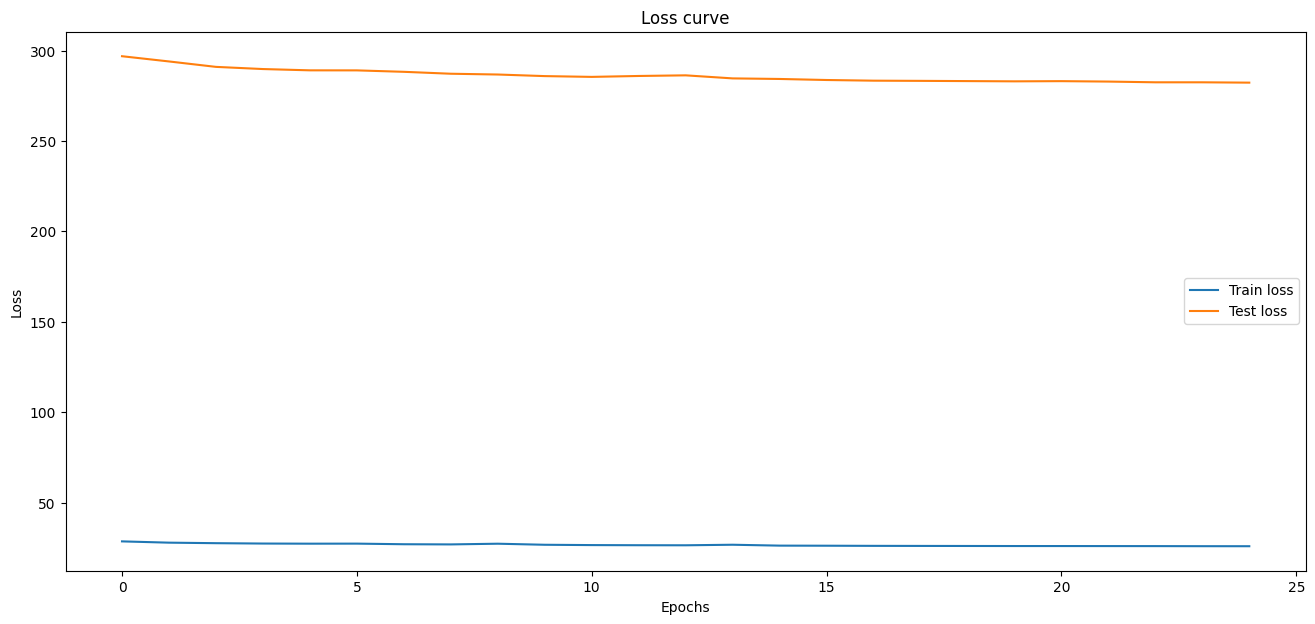

In [18]:
# Loss
# setup a plot
plt.figure(figsize=(16, 7))

# get the num of epochs
epoch_plot = range(len(model_results['test_loss']))

# ploting
plt.plot(epoch_plot, model_results['train_loss'], label='Train loss')
plt.plot(epoch_plot, model_results['test_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

In [22]:
model.load_state_dict(best_model)
model.eval()


with torch.no_grad():
  train_predictions = np.array([])
  for x in x_vector_train:
      y_pred = model(torch.tensor(x).to(device))
      y_pred = y_pred.last_hidden_state[:,-1,0]
      y_pred = y_pred.cpu().detach().numpy()
      train_predictions = np.concatenate((train_predictions, y_pred))


  val_predictions = np.array([])
  for x in x_vector_val:
      y_pred = model(torch.tensor(x).to(device))
      y_pred = y_pred.last_hidden_state[:,-1,0]
      y_pred = y_pred.cpu().detach().numpy()
      val_predictions = np.concatenate((val_predictions, y_pred))


  test_predictions = np.array([])
  for x in x_vector_test:
      y_pred = model(torch.tensor(x).to(device))
      y_pred = y_pred.last_hidden_state[:,-1,0]
      y_pred = y_pred.cpu().detach().numpy()
      test_predictions = np.concatenate((test_predictions, y_pred))


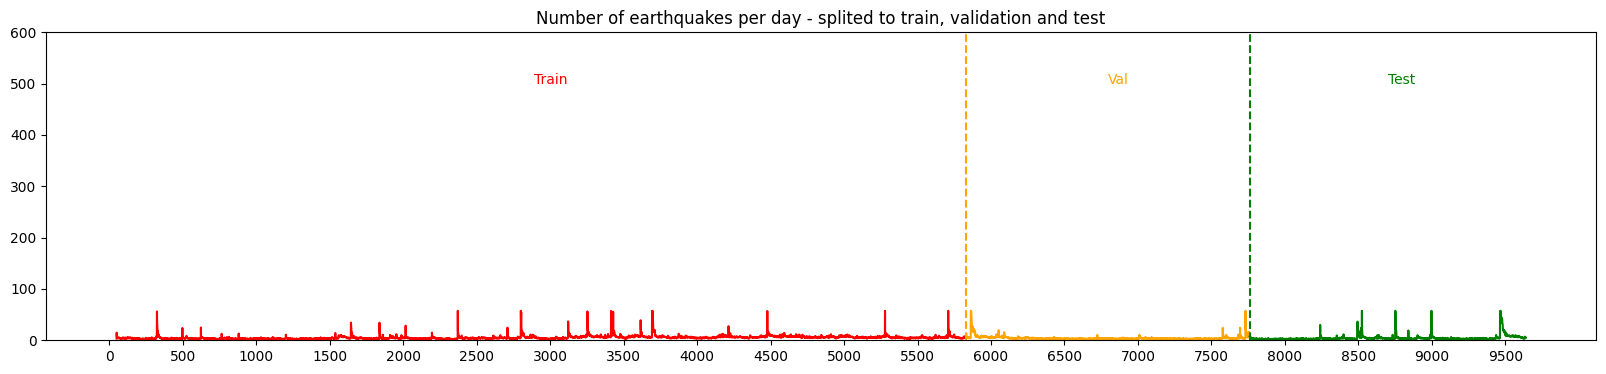

In [34]:
plotting_y_train_pred = np.array([None] * window_size + list(train_predictions) + [None] * (num_data_points-(split_train_val+window_size)))
plotting_y_val_pred = np.array([None] * (split_train_val+window_size) + list(val_predictions) + [None] * (num_data_points-(split_val_to_test+window_size)))
plotting_y_test_pred = np.array([None] * (split_val_to_test+window_size) + list(test_predictions)[:-1])

## plots
data_date = np.arange(num_data_points)
fig2 = plt.figure(figsize=(20, 4))
plt.title("Predictions: Number of earthquakes per day - splited to train, validation and test")

xticks = data_date[0:num_data_points:500]
plt.xticks(xticks, xticks)

plt.plot(data_date, plotting_y_train_pred, label="Number of earthquakes (train)", color='red')
plt.plot(data_date, plotting_y_val_pred, label="Number of earthquakes (validation)", color='orange')
plt.plot(data_date, plotting_y_test_pred, label="Number of earthquakes (test)", color='green')

plt.text(x=(split_train_val) / 2, y=500, s="Train", color="red")
plt.text(x=(split_val_to_test + split_train_val) / 2 +window_size, y=500, s="Val", color='orange')
plt.text(x=(num_data_points + (split_val_to_test+window_size)) / 2, y=500, s="Test", color='green')

plt.axvline(x=split_train_val+window_size, color='orange', linestyle='--')
plt.axvline(x=split_val_to_test+window_size, color='green', linestyle='--')

plt.ylim(0, 600)

plt.show()

In [36]:
torch.save(model, 'Model/earthquake_predictor.pt')